In [71]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

class Hypothesis:
	def __init__(self, pclass, sex, age, sibsp):
		self.pclass = pclass
		self.sex = sex
		self.age = age
		self.sibsp = sibsp
	def __repr__(self):
		return '(%d, %d, %f, %d)' %(self.pclass, self.sex, self.age, self.sibsp)


In [72]:
X = []   # features
Y = []   # target
dic1 = {'1st':1, '2nd':2, '3rd':3}
dic2 = {'male':1, 'female':0}
with open('Titanic.csv') as f:
	reader = csv.reader(f)
	for row in reader:
		if reader.line_num == 1:
			continue;
		if row[5] == 'NA':
			row[5] = 0
		#Hypothesis(dic1[row[1]], dic2[row[4]], float(row[5]), int(row[6]))
		X.append([dic1[row[1]], dic2[row[4]], float(row[5]), int(row[6])])
		Y.append(int(row[2]))

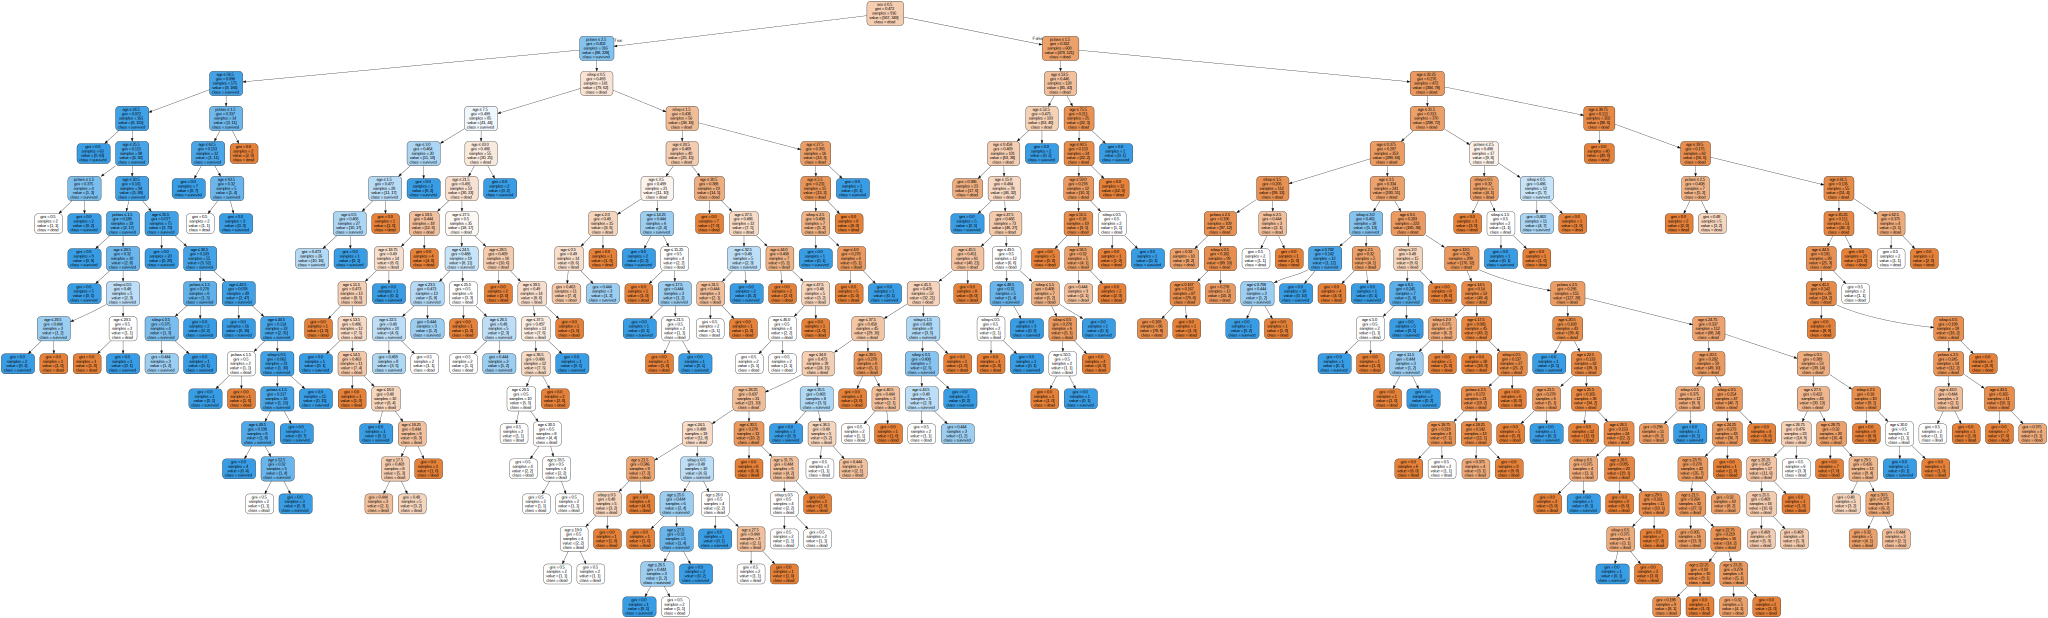

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
clf = tree.DecisionTreeClassifier()    # full tree (all prarameters default)
clf = clf.fit(X_train, Y_train)        # only spport float/int
#print(clf.predict([[1,0,29,0]]))
dot_data = tree.export_graphviz(clf, out_file = None,
								feature_names = ['pclass', 'sex', 'age', 'sibsp'],
								class_names = ['dead', 'survived'],
								filled = True, rounded = True,
								special_characters=True)
graph = graphviz.Source(dot_data)
graph
#graph.render("titan")


In [73]:
def accuraccy2Survive_die(X, Y, clf):
    Y_predict = clf.predict(X)
    survive = 0
    countPositive = 0
    dead = 0
    countNegative = 0
    for i, j in zip(Y, Y_predict):
        if j==1:
            countPositive += 1
            if i==1:
                survive += 1
        else:
            countNegative += 1
            if i==0:
                dead += 1
    accur_survive = survive/countPositive
    accur_dead = dead/countNegative
    return [accur_survive, accur_dead]

print("accuracy of survive/die for training data:", accuraccy2Survive_die(X_train, Y_train, clf))
print("accuracy of survive/die for testing data:", accuraccy2Survive_die(X_test, Y_test, clf))

accuracy of survive/die for training data: [0.9243986254295533, 0.872]
accuracy of survive/die for testing data: [0.7153846153846154, 0.779467680608365]


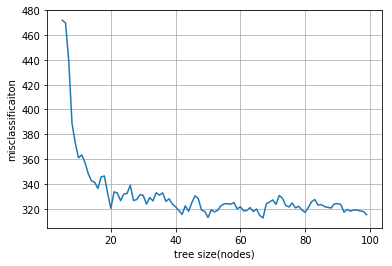

In [74]:
def calMisclass(X, Y, cv_):     #cv: how many nodes
    length = len(Y)
    clf2 = tree.DecisionTreeClassifier()
    scores = cross_val_score(clf2, X, Y, cv=cv_)
    misclass = (1-scores.mean())*length
    return misclass

x = range(5,100)
misClassification = []
for i in x:
    misClassification.append(calMisclass(X,Y,i))
plt.plot(x, misClassification) 
plt.xlabel('tree size(nodes)')  # not tree size, just the number of cv folds
plt.ylabel('misclassificaiton')
plt.grid(True)

# size of tree: the number of nodes
# cross_val_score: the accuracy

### Why do I choose tree size = 20 ?
After 20, the reduction of misclassification is negligible. And with more nodes, it's more likely overfitting.

In [75]:
dt = tree.DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split': [10,15,20],    # min samples for splitting one node
              'max_depth': [6,8],            # layers from root(0) to leaf 
              'min_samples_leaf': [5,10,15], # min samples needed to be the leaf node
              'max_leaf_nodes': [10,15,20,25],
             }
gs = GridSearchCV(dt, param_grid, cv=20) # 20 folds cross-validation
gs.fit(X,Y)
#gs.grid_scores_   # is a 2-d list: [0]-param [1]-mean
#gs.cv_results_    # replacement ???
maxMean = 0
param = {}
for ele in gs.grid_scores_:
    if ele[1] > maxMean:
        maxMean = ele[1]
        param = ele[0]
print(maxMean, param)

# find max_mean_score and its parameter

0.8036669213139801 {'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}


/home/jiang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


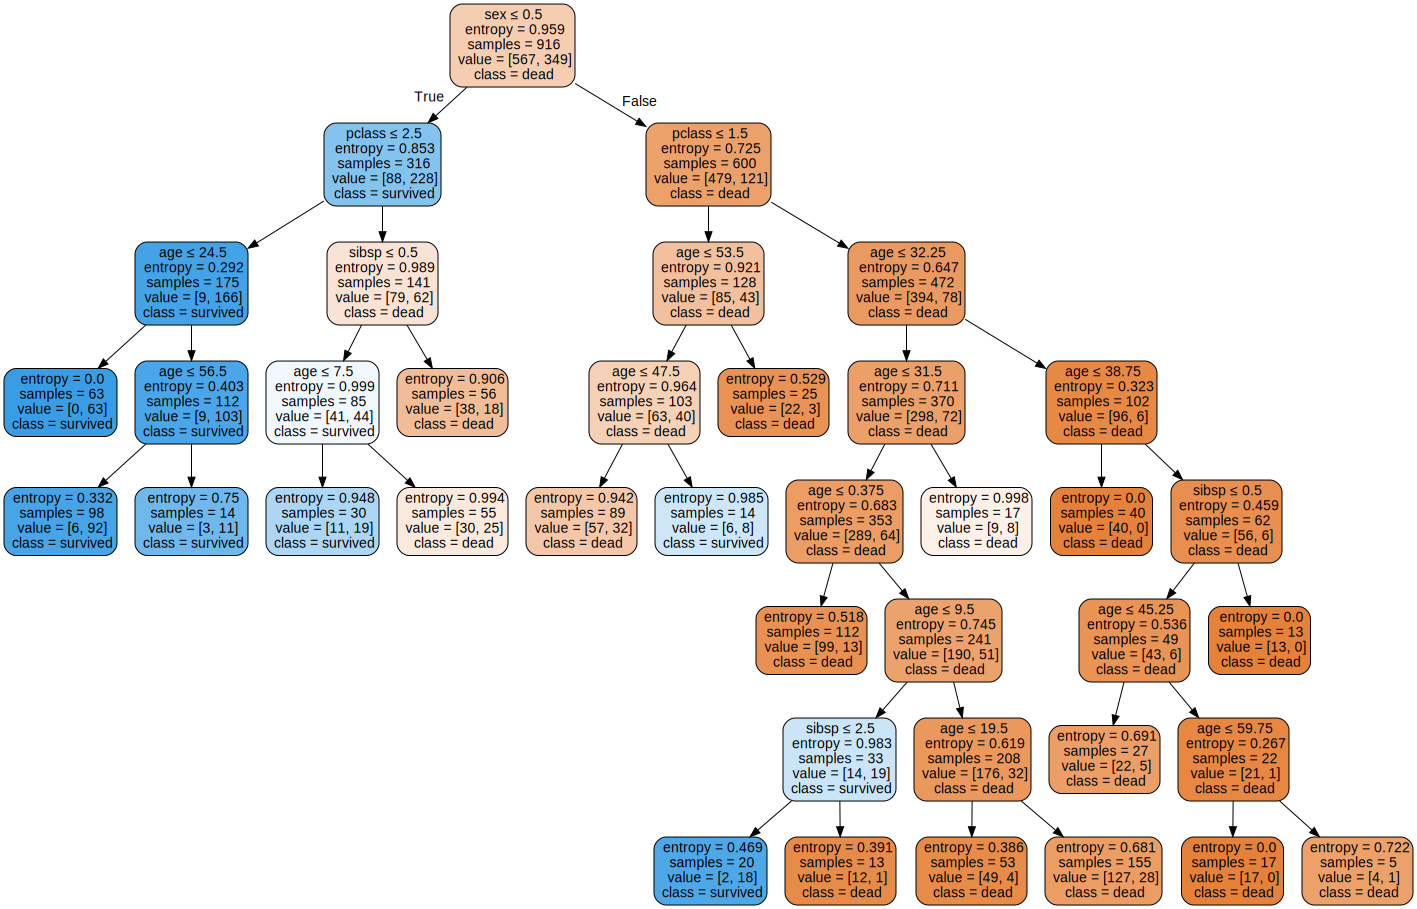

In [66]:
finalClf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                      max_leaf_nodes=20, min_samples_leaf=5,
                                      min_samples_split=10)

clf4 = finalClf.fit(X_train, Y_train)
#print(clf.predict([[1,0,29,0]]))
dot_data = tree.export_graphviz(clf4, out_file = None,
								feature_names = ['pclass', 'sex', 'age', 'sibsp'],
								class_names = ['dead', 'survived'],
								filled = True, rounded = True,
								special_characters=True)
graph4 = graphviz.Source(dot_data)
#graph4.render('prunedtree')
graph4

In [76]:
print("For pruned tree:")
print("accuracy of survive/die for training data :", accuraccy2Survive_die(X_train, Y_train, clf4))
print("accuracy of survive/die for testing data:", accuraccy2Survive_die(X_test, Y_test, clf4))

For pruned tree:
accuracy of survive/die for training data : [0.8828451882845189, 0.7961595273264401]
accuracy of survive/die for testing data: [0.8316831683168316, 0.7705479452054794]


## report
### After pruning tree, the accuracy for testing data improves significantly while the accuracy for training data decreases slightly. Because the full tree is too specific, it causes overfitting problem.

#### The accuracy of the full tree:
accuracy of survive/die for training data: [0.9243986254295533, 0.872]

accuracy of survive/die for testing data: [0.7153846153846154, 0.779467680608365]